In [26]:
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result,create_qaoa_circ
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile,Aer
from qaoa import get_expectation_qaoa,create_classical_qaoa_circ
import pickle
from numpy.random import rand

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
reps = 2
ncities = 4

In [88]:
G = create_tsp_graph(ncities)

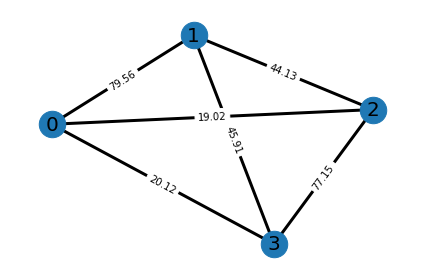

In [89]:
plot_tsp_graph(G)

In [90]:
expectation = get_expectation(G,reps,shots=1024,log_intermediate_counts=True)

res = minimize(expectation,
               [1. if i<reps*2 else np.random.rand()*2 for i in range(reps*4)],
                      method='COBYLA',
                      options = {'tol' : 1e-6,'disp' : True})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


Current expected cost: 214.75
Current expected cost: 214.75
Current expected cost: 214.75
Current expected cost: 214.75
Current expected cost: 214.75
Current expected cost: 185.56
Current expected cost: 191.51
Current expected cost: 185.56
Current expected cost: 183.3
Current expected cost: 190.9
Current expected cost: 188.1
Current expected cost: 183.3
Current expected cost: 180.82
Current expected cost: 180.82
Current expected cost: 199.72
Current expected cost: 180.82
Current expected cost: 200.85
Current expected cost: 220.16
Current expected cost: 204.53
Current expected cost: 196.46
Current expected cost: 180.82
Current expected cost: 191.52
Current expected cost: 200.51
Current expected cost: 180.63
Current expected cost: 212.7
Current expected cost: 187.86
Current expected cost: 197.19
Current expected cost: 180.63
Current expected cost: 191.26
Current expected cost: 180.63
Current expected cost: 200.99
Current expected cost: 180.63
Current expected cost: 215.89
Current expecte

In [91]:
with open(".\data\G", "wb") as fp:   #Pickling
    pickle.dump(G,fp)

In [92]:
res

     fun: 169.94304627570799
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 117
  status: 1
 success: True
       x: array([1.31958653, 1.31878708, 0.76639748, 0.76706084, 1.77973738,
       1.30082216, 1.47561448, 2.41421993])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


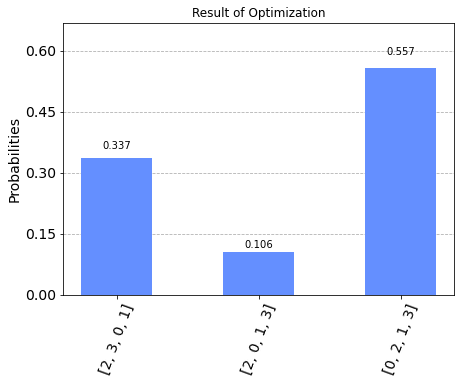

In [93]:
fig,counts = analyse_result(G,res.x,reps=reps,transform_labels_to_path=True,filter_unique_path=True,save_plot=True)
fig

In [94]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

[2, 3, 0, 1] : 345    cost = 220.96
[2, 0, 1, 3] : 109    cost = 221.64
[0, 2, 1, 3] : 570    cost = 129.18


In [95]:
solve_tsp_classical(G)

([0, 2, 1, 3], 129.17590372653362)

In [98]:
expectation_qaoa = get_expectation_qaoa(G,reps,shots=1024,penalty=0.5,log_intermediate_counts=True)

res_qaoa = minimize(expectation_qaoa,
               [1 for _ in range(reps*2)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True})

Current expected cost: 318.07
Current expected cost: 318.25
Current expected cost: 318.25
Current expected cost: 318.07
Current expected cost: 318.06
Current expected cost: 313.6
Current expected cost: 318.25
Current expected cost: 318.25
Current expected cost: 318.07
Current expected cost: 313.6
Current expected cost: 317.69
Current expected cost: 281.86
Current expected cost: 310.08
Current expected cost: 275.59
Current expected cost: 221.34
Current expected cost: 279.96
Current expected cost: 222.77
Current expected cost: 221.15
Current expected cost: 244.24
Current expected cost: 235.31
Current expected cost: 225.62
Current expected cost: 221.15
Current expected cost: 224.01
Current expected cost: 223.15
Current expected cost: 221.15
Current expected cost: 221.34
Current expected cost: 221.06
Current expected cost: 221.06
Current expected cost: 221.06
Current expected cost: 221.06
Current expected cost: 221.15
Current expected cost: 221.06
Current expected cost: 221.06
Current expe

In [99]:
res_qaoa

     fun: 221.0598270149642
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 40
  status: 1
 success: True
       x: array([-0.0078852 ,  0.00219782,  1.00112483,  1.8149632 ])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


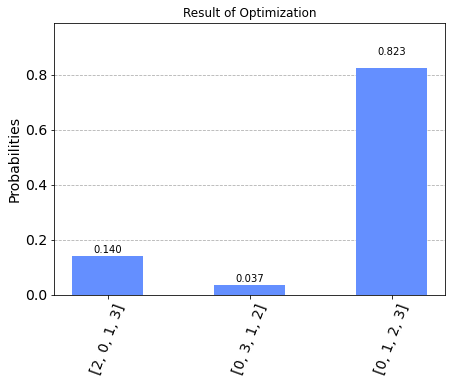

In [100]:
fig,counts = analyse_result(G,np.hstack([np.array([1. for _ in range(reps*2)]),res_qaoa.x]),reps=reps,transform_labels_to_path=True,filter_unique_path=True)
fig

## If 0,1,2,3,4 is "good" -> the algorithm almost always converges to that value 

In [223]:
def compute_circuit_sizes(ncities_max=6,reps=1):
    sizes_alternating_operator = []
    sizes_qaoa = []
    simulator = Aer.get_backend('aer_simulator')
    x = []
    
    for ncities in range(2,ncities_max+1,1):
        G = create_tsp_graph(ncities)
        x.append(ncities)
        
        alt_op = create_qaoa_circ(G,reps=reps)
        alt_op = transpile(alt_op, simulator,optimization_level = 3)
        sizes_alternating_operator.append(alt_op.depth())
        
        qaoa = create_classical_qaoa_circ(G,reps=reps)
        qaoa = transpile(qaoa, simulator,optimization_level = 1)
        sizes_qaoa.append(qaoa.depth())
    
    
    return (x,sizes_alternating_operator,sizes_qaoa)
        

In [225]:
compute_circuit_sizes(5,2)

([2, 3, 4, 5], [136, 771, 1656, 2738], [12, 37, 85, 211])

In [242]:
a = {'1000000101000010': 180.866, '1000010000100001': 234.667, '0010100001000001': 238.15}
b ={'1000000101000010': 210, '1000010000100001': 443, '0010100001000001': 371}

In [246]:
'0010100001000001' in b

True